## Minimizer template

This notebook contains the basic syntax required to run a minimization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.sampler import emcee_sampler
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True,)

In [5]:
use_nyx=False
if use_nyx:
    from lace.emulator import p1d_archive_Nyx
    archive=p1d_archive_Nyx.archiveP1D_Nyx(fname=None,verbose=False)

In [6]:
## Build emulator
if use_nyx:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'Delta2_p', 'n_p']
    kmax_Mpc=2
else:
    paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
    kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.23 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [7]:
free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
free_param_names=["As","ns","ln_tau_0"]
prior=0.5

In [8]:
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior,include_CMB=False)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [9]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,verbose=False,
                        nwalkers=10,
                        save_chain=True, ## Small test run, don't create a save folder
                        progress=True)

Made directory:  /Users/font/Projects/LaCE_manager//lace_manager/sampler/chains//chain_21


In [10]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


In [11]:
n_burn_in=20
n_steps=200 ## Max number of steps to run

if False:
    start = time.time()
    sampler.run_sampler(n_burn_in,n_steps,parallel=False)
    end = time.time()
    sampler_time = end - start
    print("Sampling took {0:.1f} seconds".format(sampler_time))

In [12]:
#sampler.write_chain_to_file(residuals=True,plot_nersc=True,plot_delta_lnprob_cut=50)

In [13]:
#sampler.plot_corner(cmb_prior=False,plot_params=['$\\Delta^2_\\star$','$n_\\star$'],delta_lnprob_cut=50)

# Try scipy minimizer

In [14]:
results=like.maximise_posterior()

In [15]:
best_fit=results.x
print(best_fit)

[0.43534768 0.47469439 0.50491367]


In [16]:
best_fit_params=like.parameters_from_sampling_point(best_fit)
print('best fit parameters')
for p in best_fit_params:
    pname=p.name
    latex_name=emcee_sampler.param_dict[pname]
    if latex_name in sampler.truth:
        true=sampler.truth[latex_name]
    else:
        true=0.0
    print(p.info_str(),'truth',true)

best fit parameters
As = 2.009876646839744e-09 truth 2.006055e-09
ns = 0.9659511020848649 truth 0.967565
ln_tau_0 = 0.001965466255494208 truth 0.0


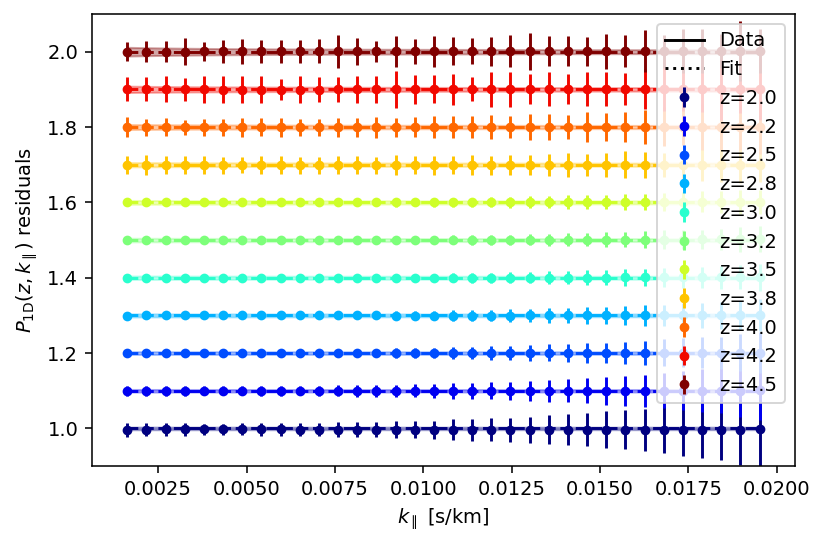

In [17]:
like.plot_p1d(values=best_fit,residuals=True)

# Try iminuit minimizer

In [18]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

In [19]:
minimizer.minimize(compute_hesse=True)

will run migrad
will compute Hessian matrix


best-fit values = [0.43537027 0.47472876 0.504895  ]


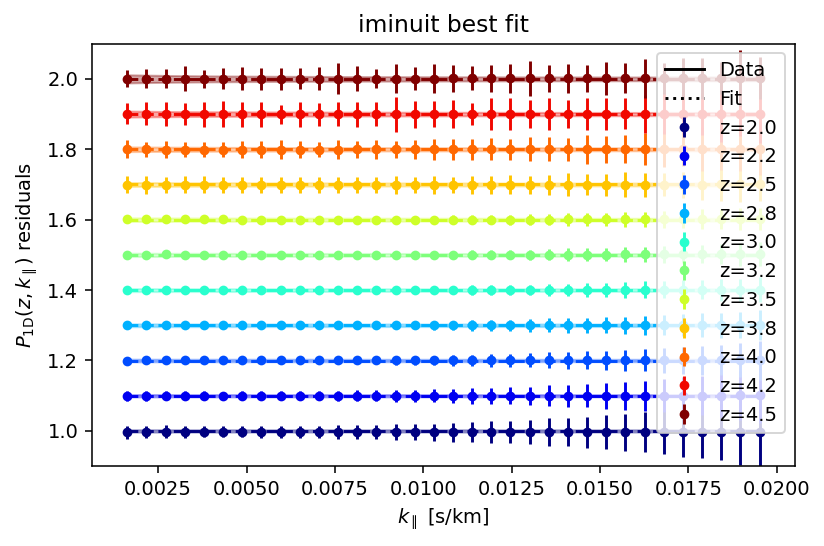

In [20]:
minimizer.plot_best_fit()

compute true values for As ns


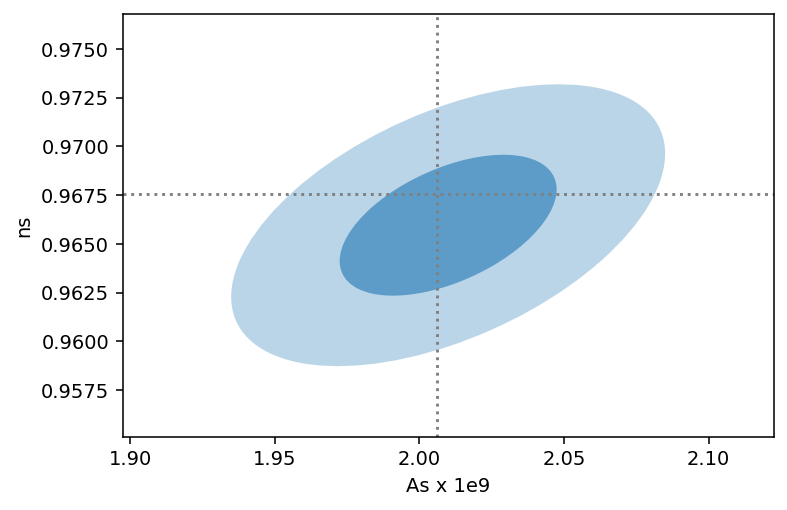

In [21]:
minimizer.plot_ellipses('As','ns')

### Access the actual minimizer object from iminuit

In [22]:
minimizer.minimizer.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -178.3                     │              Nfcn = 138              │
│ EDM = 1.89e-15 (Goal: 0.0001)    │            time = 3.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.435   │   0.018   │            │            │         │         │       │
│ 1 │ x1   │   0.475   │   0.023   │            │            │         │         │       │
│ 2 │ x2   │   0.505   │   0.015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        x0        x1        x2 │
├────┼───────────────────────────────┤
│ x0 │  0.000322  0.000206 -0.000248 │
│ x1 │  0.000206  0.000511 -0.000231 │
│ x2 │ -0.000248 -0.000231  0.000219 │
└────┴───────────────────────────────┘

W MnMinos UP value has changed, need to update FunctionMinimum class


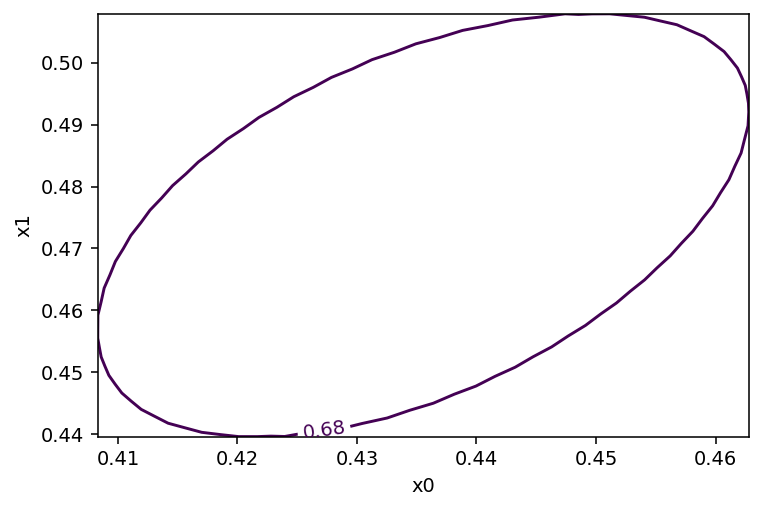

In [23]:
minimizer.minimizer.draw_mncontour("x0", "x1")

(array([0.39947124, 0.40194691, 0.40442258, 0.40689825, 0.40937392,
        0.41184959, 0.41432526, 0.41680093, 0.4192766 , 0.42175227,
        0.42422794, 0.42670361, 0.42917928, 0.43165495, 0.43413062,
        0.43660629, 0.43908196, 0.44155763, 0.4440333 , 0.44650897,
        0.44898464, 0.45146031, 0.45393598, 0.45641165, 0.45888732,
        0.46136299, 0.46383866, 0.46631433, 0.46879   , 0.47126567]),
 array([-176.31948786, -176.58464952, -176.83137597, -177.05953907,
        -177.26902224, -177.45971684, -177.63152486, -177.78436197,
        -177.91815944, -178.03286508, -178.12844285, -178.20487639,
        -178.26212106, -178.30031057, -178.31937056, -178.31937306,
        -178.30038048, -178.26242868, -178.20579845, -178.13039953,
        -178.03642566, -177.9240257 , -177.793367  , -177.6445881 ,
        -177.47787927, -177.29342699, -177.09158298, -176.87236243,
        -176.63607853, -176.38297178]))

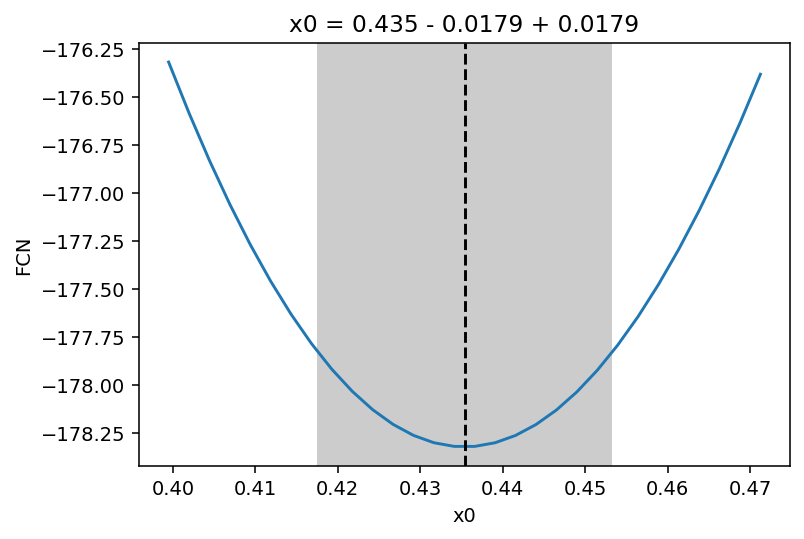

In [24]:
minimizer.minimizer.draw_mnprofile("x0")